In [1]:
import numpy as np
import random
import itertools
import scipy.stats
import matplotlib.pyplot as plt


We assume a logistic decision rule:
$$
P(Y = y | X = x) = \frac{1}{1 + \exp(-yx^Tw)}
$$
where $$y \in \{+1,-1\}, x,w \in \mathbb{R}^d$$ 

In [2]:
#Computes P(Y = y| X = x)
def Pr_Y_given_X(y,X,w):
    return 1/(1 + np.exp(-y*(np.matmul(X,w))))

We assume that $$X = [X_1, \dots, X_k] \text{ where } X_i \sim Bern(p_i)$$

In [3]:
#Returns all possible outcomes
def partitions(n, b):
    masks = np.identity(b, dtype=int)
    for c in itertools.combinations_with_replacement(masks, n): 
        yield sum(c)

Let $\mathcal{X}=$ the set of all possible values of $\{0,1\}^k$. Then we have:
\begin{align}
P(Y = y) = \sum_{x \in \mathcal{X}}P(Y = y | X = x)P(X = x)
\end{align}

In [4]:
#Computes the probability P(X = x) = P(X1 = x1)*P(X2 = x2)*...*P(X2k = x2k)
def binary_prob(x,probs):
    prod = 1
    for i in range(len(probs)):
        prod *= (probs[i]**x[i])*((1 - probs[i])**(1 - x[i]))
    return prod

In [5]:
probs = [0.3, 0.2, 0.5, 0.7]
lst = list(itertools.product([0, 1], repeat=len(probs)))

AllX = np.array(lst)
print(AllX)
def PrX(probs,AllX):
    def binary_prob(x):
        prod = 1
        for i in range(len(probs)):
            prod *= (probs[i]**x[i])*((1 - probs[i])**(1 - x[i]))
        return prod
    return np.apply_along_axis(binary_prob, 1, AllX)
print(PrX(probs, AllX))

[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]
[0.084 0.196 0.084 0.196 0.021 0.049 0.021 0.049 0.036 0.084 0.036 0.084
 0.009 0.021 0.009 0.021]


In [6]:
#Computes P(Y = y), where w has an offset coordinate
def Pr_Y(y,w,probs):
    AllX = np.array(list(itertools.product([0, 1],repeat=len(probs))))
    AllXOffset = np.hstack((AllX, np.ones((AllX.shape[0],1))))
    return np.dot(Pr_Y_given_X(y,AllXOffset,w), PrX(probs,AllX))

In [7]:
w = np.array([0.1, 0.5, 0.2, 0.1, -0.1])
probs1 = [0.1, 0.2, 0.5, 0.8]
probs2 = [0, 0.2, 0.5, 0.9]
PrY = Pr_Y(1,w,probs1)
print("P(Y = 1) for group 1:", PrY)
PrY = Pr_Y(1,w,probs2)
print("P(Y = 1) for group 2:", PrY)

P(Y = 1) for group 1: 0.54652348108409
P(Y = 1) for group 2: 0.5465419179991764


Equality of odds: we want the following
\begin{align}
P(\hat{Y} = \hat{y} | Y = y) = &\sum_{x \in \mathcal{X}}P(\hat{Y} = \hat{y} | Y = y, X = x)P(X = x | Y = y)\\
&= \frac{\sum_{x \in \mathcal{X}}P(\hat{Y} = \hat{y} | X = x)P(Y = y| X = x)P(X = x)}{P(Y = y)}
\end{align}
to be the same for both groups for $y, \hat{y} \in \{+1,-1\}.$

So we are interested in the following function: \begin{align*}
difference &= P(\hat{Y}_1 = 1| Y_1 = y) - P(\hat{Y}_2 = 1 | Y_2 = y) \\
&= \frac{\sum_{x \in \mathcal{X}}P(\hat{Y}_1 = 1 | X_1 = x)P(Y_1 = y| X_1 = x)P(X_1 = x)}{P(Y_1 = y)} - \frac{\sum_{x \in \mathcal{X}}P(\hat{Y}_2 = 1 | X_2 = x)P(Y_2 = y| X_2 = x)P(X_2 = x)}{P(Y_2 = y)} \\
&= \frac{\sum_{x \in \mathcal{X}}P(\hat{Y}_1 = 1 | X_1 = x)P(Y_1 = y| X_1 = x)P(X_1 = x)}{P(Y_1 = y)} - \frac{\sum_{x \in \mathcal{X}}P(\hat{Y}_1 = 1 | X_1 = x)P(Y_1 = y| X_1 = x)P(X_2 = x)}{P(Y_2 = y)} \\
&= \sum_{x \in \mathcal{X}}P(\hat{Y}_1 = 1|X_1 = x)P(Y_1 = y| X_1 = x)\left(\frac{P(X_1 = x)}{P(Y_1 = y)} - \frac{P(X_2 = x)}{P(Y_2 = y)}\right)
\end{align*}

$\textbf{Lemma}$.
We show that if two groups have probabilities $[p_1, p_2, \dots, p_k]$ and $[\bar{p}_1,p_2, \dots, p_k]$, $p_1 > \bar{p}_1$, and $w^\natural_1 > 0$, then increasing $\hat{w}_1$ increases the difference in opportunity between the two groups. 

$\textit{Proof}$.
\begin{align*}
\frac{dP(\hat{Y} = 1 | Y = 1)}{d\hat{w}_1} &= \frac{\sum_{\substack{x \in \mathcal{X} \\ x_1 = 1}}\frac{\exp(-x^T\hat{w})}{(1 + \exp(-x^T\hat{w}))^2}P(Y = 1 | X = x)P(X = x)}{P(Y = 1)} \\
&= \frac{\sum_{\substack{x \in \mathcal{X} \\ x_1 = 1}}\frac{\exp(-x^T\hat{w})}{(1 + \exp(-x^T\hat{w}))^2}P(Y = 1 | X = x)P(X = x)}{\sum_{x: x_1 = 1}P(Y = 1 | X = x)P(X = x) + \sum_{x: x_1 = 0}P(Y = 1 | X = x)P(X = x)} \\
&= \frac{\sum_{\substack{x \in \mathcal{X} \\ x_1 = 1}}\frac{\exp(-x^T\hat{w})}{(1 + \exp(-x^T\hat{w}))^2}P(Y = 1 | X = x)p_1\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}}{\sum_{x: x_1 = 1}P(Y = 1 | X = x)p_1\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i} + \sum_{x: x_1 = 0}P(Y = 1 | X = x)(1-p_1)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}} \\
&= \frac{p_1\sum_{\substack{x \in \mathcal{X} \\ x_1 = 1}}\frac{\exp(-x^T\hat{w})}{(1 + \exp(-x^T\hat{w}))^2}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}}{p_1\sum_{x: x_1 = 1}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i} -p_1\sum_{x: x_1 = 0}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i} + \sum_{x: x_1 = 0}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}} \\
&= \frac{p_1\sum_{\substack{x \in \mathcal{X} \\ x_1 = 1}}\frac{\exp(-x^T\hat{w})}{(1 + \exp(-x^T\hat{w}))^2}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}}{p_1\left(\sum_{x: x_1 = 1}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i} -\sum_{x: x_1 = 0}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}\right) + \sum_{x: x_1 = 0}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}}
\end{align*} 
We observe for group 2, their opportunity is the same expression, except all the $p_1$'s are replaced with $\bar{p}_1$. Thus, the ratio of their numerators is $p_1/\bar{p}_1$. The ratio of their denominators is $\frac{p_1\cdot s + x}{\bar{p}_1 \cdot s + x}$, where $x = \sum_{x: x_1 = 0}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i} > 0$. Since $w^\natural_1 > 0$, we have that $\sum_{x: x_1 = 1}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i} > \sum_{x: x_1 = 0}P(Y = 1 | X = x)\prod_{i = 2}^{2^k}p_i^{x_i}(1-p_i)^{1-x_i}$. Thus, $\frac{p_1\cdot s + x}{\bar{p}_1 \cdot s + x} < \frac{p_1\cdot s}{\bar{p}_1 \cdot s} = \frac{p_1}{\bar{p}_1}$, so $\frac{dP(\hat{Y} = 1 | Y = 1; group1)}{d\hat{w}_1} - \frac{dP(\hat{Y} = 1 | Y = 1; group2)}{d\hat{w}_1} > 0$, so the difference in opportunity increases as $\hat{w}_1$ increases.

In [8]:
#Computes the group's opportunity/disopportunity
def Pr_Yhat_given_Y(y_outcome,y_given,w_hat,w_nat,probs):
    AllX = np.array(list(itertools.product([0, 1],repeat=len(probs))))
    AllXOffset = np.hstack((AllX, np.ones((AllX.shape[0],1))))
    return np.dot(np.multiply(Pr_Y_given_X(y_outcome,AllXOffset,w_hat), 
                              Pr_Y_given_X(y_given, AllXOffset,w_nat)),PrX(probs, AllX)) / Pr_Y(y_given,w_nat,probs)

Predictive Value Parity: we want the following
\begin{align}
P(Y = y | \hat{Y} = \hat{y}) = &\sum_{x \in \mathcal{X}}P(Y = y | \hat{Y} = \hat{y}, X = x)P(X = x | \hat{Y} = \hat{y})\\
&= \frac{\sum_{x \in \mathcal{X}}P(Y = y | X = x)P(\hat{Y} = \hat{y}| X = x)P(X = x)}{P(\hat{Y} = \hat{y})}
\end{align}
to be the same for both groups for $y, \hat{y} \in \{+1,-1\}.$

In [9]:
#Computes the group's positive/negative predictive value 
def Pr_Y_given_Yhat(y_outcome,y_given,w_hat,w_nat,probs):
    AllX =np.array(list(itertools.product([0, 1],repeat=len(probs))))
    AllXOffset = np.hstack((AllX, np.ones((AllX.shape[0],1))))
    return np.dot(np.multiply(Pr_Y_given_X(y_outcome,AllXOffset,w_nat), 
                              Pr_Y_given_X(y_given,AllXOffset,w_hat)),PrX(probs, AllX)) / Pr_Y(y_given,w_hat,probs)


In [32]:
probs1 = [0.2, 0.2, 0.2, 0.2]
probs2 = [0.7, 0.2, 0.2, 0.2]
w_hat = np.array([0.3,0.2,-0.1,0.4,-0.3])
w_nat = np.array([0.3,0.2,-0.1,0.4,-0.3])
#w_nat = np.array([0.3, 0.1, 0.2, 1, -0.3])
print(Pr_Y(1, w_nat, probs1) - Pr_Y(1, w_nat, probs2))
PrYhatGivenY1 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs1)
PrYhatGivenY2 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs2)
print("P(Yhat = 1 | Y = 1) for group 1: ", PrYhatGivenY1)
print("P(Yhat = 1 | Y = 1) for group 2: ", PrYhatGivenY2)
print("difference:", PrYhatGivenY1 - PrYhatGivenY2)
PrYGivenYhat1 = Pr_Y_given_Yhat(1,-1,w_hat, w_nat, probs1)
PrYGivenYhat2 = Pr_Y_given_Yhat(1,-1,w_hat, w_nat, probs2)
print("P(Y = 1 | Yhat = 1) for group 1: ", PrYGivenYhat1)
print("P(Y = 1 | Yhat = 1) for group 2: ", PrYGivenYhat2)
print("difference:", PrYGivenYhat1 - PrYGivenYhat2)

-0.03709802581935784
P(Yhat = 1 | Y = 1) for group 1:  0.4715950738817385
P(Yhat = 1 | Y = 1) for group 2:  0.5087442131914165
difference: -0.037149139309678
P(Y = 1 | Yhat = 1) for group 1:  0.4597827356953402
P(Y = 1 | Yhat = 1) for group 2:  0.4959485448284248
difference: -0.03616580913308465


Our strategy will be to favor minimizing the difference in odds, rather than predictive value, because we experimentally find that the difference in predictive value is quite small compared to the potential difference in odds. The next lemma will illustrate this fact:

$\textbf{Lemma}.$ The difference in predictive value is bounded by $$\max_{P(Y = 1 | X = x)}P(Y = 1 | \hat{Y} = 1) - \min_{P(Y = 1 | X = x)}P(Y = 1 | \hat{Y} = 1)$$
$\textit{Proof}.$ A group's predictive value is given by: 
\begin{align*}
P(Y = 1 | \hat{Y} = 1) = 
&= \frac{\sum_{x \in \mathcal{X}}P(Y = 1 | X = x)P(\hat{Y} = 1| X = x)P(X = x)}{P(\hat{Y} = 1)} \\
&= \frac{\sum_{x \in \mathcal{X}}P(Y = 1 | X = x)P(\hat{Y} = 1| X = x)P(X = x)}{\sum_{x \in \mathcal{X}}P(\hat{Y} = 1 | X = x)P(X = x)} 
\end{align*}
Let $m = \max_{P(Y = y | X =x)}$. Then we have:
\begin{align*}
\frac{\sum_{x \in \mathcal{X}}P(Y = 1 | X = x)P(\hat{Y} = 1| X = x)P(X = x)}{\sum_{x \in \mathcal{X}}P(\hat{Y} = 1 | X = x)P(X = x)}  &\leq \frac{\sum_{x \in \mathcal{X}}m\cdot P(\hat{Y} = 1| X = x)P(X = x)}{\sum_{x \in \mathcal{X}}P(\hat{Y} = 1 | X = x)P(X = x)}  
\leq m
\end{align*}
Let $l = \min_{P(Y = y | X = x)}$. Then we have: 
\begin{align*}
\frac{\sum_{x \in \mathcal{X}}P(Y = 1 | X = x)P(\hat{Y} = 1| X = x)P(X = x)}{\sum_{x \in \mathcal{X}}P(\hat{Y} = 1 | X = x)P(X = x)}  &\geq \frac{\sum_{x \in \mathcal{X}}l\cdot P(\hat{Y} = 1| X = x)P(X = x)}{\sum_{x \in \mathcal{X}}P(\hat{Y} = 1 | X = x)P(X = x)}  
\geq l
\end{align*}

We observe that the above is not a good bound in practice in that it overestimates the difference in predictive value. The reason is that all the $P(Y = 1 | X = x)$ are equal to each other only if the $w^\natural$ is the $0$ vector, and in this case, the difference in predictive value will be 0. 

From the equation for the difference in odds, we also observe that it is bounded as well, equal to 
\begin{align*}
\sum_{x \in \mathcal{X^*}}P(Y_1 = y| X_1 = x)\left(\frac{P(X_1 = x)}{P(Y_1 = y)} - \frac{P(X_2 = x)}{P(Y_2 = y)}\right)
\end{align*}
where $\mathcal{X^*}$ is the set of all $x$ such that $\frac{P(X_1 = x)}{P(Y_1 = y)} - \frac{P(X_2 = x)}{P(Y_2 = y)} > 0$ (or vice-versa). However, the above Lemma can still be useful, as the following example shows, and it gives intuition as to why the difference in predictive value is less sensitive to change.

In [11]:
#This example shows that even using the above bound, 
#we can still see how the maximum difference in parity is less than the maximum difference in odds in this example.
probs1 = [0.1, 0.2, 0.2, 0.2]
probs2 = [0.1, 0.2, 0.2, 0.6]
w_hat = np.array([0.2,0.1,0.2,1000,-10.7])
w_nat = np.array([0.2, 0.1, 0.2, 0.1, -0.7])
PrYhatGivenY1 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs1)
PrYhatGivenY2 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs2)
print("P(Yhat = 1 | Y = 1) for group 1: ", PrYhatGivenY1)
print("P(Yhat = 1 | Y = 1) for group 2: ", PrYhatGivenY2)
print("difference:", PrYhatGivenY1 - PrYhatGivenY2)
PrYGivenYhat1 = Pr_Y_given_Yhat(1,1,w_hat, w_nat, probs1)
PrYGivenYhat2 = Pr_Y_given_Yhat(1,1,w_hat, w_nat, probs2)
print("P(Y = 1 | Yhat = 1) for group 1: ", PrYGivenYhat1)
print("P(Y = 1 | Yhat = 1) for group 2: ", PrYGivenYhat2)
print("difference:", PrYGivenYhat1 - PrYGivenYhat2)
print(Pr_Y_given_X(1,[1,1,1,1,1],w_nat)) 

print(Pr_Y_given_X(1, [0,0,0,0,1], w_nat))

P(Yhat = 1 | Y = 1) for group 1:  0.21040042010221383
P(Yhat = 1 | Y = 1) for group 2:  0.6151869374363096
difference: -0.40478651733409576
P(Y = 1 | Yhat = 1) for group 1:  0.3731705373977413
P(Y = 1 | Yhat = 1) for group 2:  0.3731721887362104
difference: -1.6513384690775013e-06
0.47502081252106
0.3318122278318339


In [12]:
#Even when w_nat_1 = 0, increasing w_hat_1 still increases inequality
probs1 = [0.1, 0.2, 0.2, 0.2]
probs2 = [0.2, 0.2, 0.2, 0.2]

w_hat = np.array([0.1,0.1,0.2,1,-5.7])
#w_hat = np.array([0.2,0.1,0.2,1,-5.7])

w_nat = np.array([0.0, 0.1, 0.2, 1, -5.7])
PrYhatGivenY1 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs1)
PrYhatGivenY2 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs2)
print("P(Yhat = 1 | Y = 1) for group 1: ", PrYhatGivenY1)
print("P(Yhat = 1 | Y = 1) for group 2: ", PrYhatGivenY2)
print("difference:", PrYhatGivenY1 - PrYhatGivenY2)
PrYGivenYhat1 = Pr_Y_given_Yhat(1,-1,w_hat, w_nat, probs1)
PrYGivenYhat2 = Pr_Y_given_Yhat(1,-1,w_hat, w_nat, probs2)
print("P(Y = 1 | Yhat = 1) for group 1: ", PrYGivenYhat1)
print("P(Y = 1 | Yhat = 1) for group 2: ", PrYGivenYhat2)
print("difference:", PrYGivenYhat1 - PrYGivenYhat2)

P(Yhat = 1 | Y = 1) for group 1:  0.006108894353536415
P(Yhat = 1 | Y = 1) for group 2:  0.0061719455184507865
difference: -6.305116491437182e-05
P(Y = 1 | Yhat = 1) for group 1:  0.0047584343573635664
P(Y = 1 | Yhat = 1) for group 2:  0.004758370484619936
difference: 6.387274363063578e-08


In [13]:
#What if w_nat is negative for a feature?
probs1 = [0.1, 0.2, 0.2, 0.2]
probs2 = [0.2, 0.2, 0.2, 0.2]
w_hat = np.array([-2,0.1,0.2,1,-5.7]) #try varying from 0.0 to 0.3
w_nat = np.array([0.3, 0.1, 0.2, 1, -5.7])
PrYhatGivenY1 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs1)
PrYhatGivenY2 = Pr_Yhat_given_Y(1,1,w_hat, w_nat, probs2)
print("P(Yhat = 1 | Y = 1) for group 1: ", PrYhatGivenY1)
print("P(Yhat = 1 | Y = 1) for group 2: ", PrYhatGivenY2)
print("difference:", PrYhatGivenY1 - PrYhatGivenY2)
PrYGivenYhat1 = Pr_Y_given_Yhat(1,-1,w_hat, w_nat, probs1)
PrYGivenYhat2 = Pr_Y_given_Yhat(1,-1,w_hat, w_nat, probs2)
print("P(Y = 1 | Yhat = 1) for group 1: ", PrYGivenYhat1)
print("P(Y = 1 | Yhat = 1) for group 2: ", PrYGivenYhat2)
print("difference:", PrYGivenYhat1 - PrYGivenYhat2)

P(Yhat = 1 | Y = 1) for group 1:  0.0053659387269998655
P(Yhat = 1 | Y = 1) for group 2:  0.0047301588112818645
difference: 0.0006357799157180009
P(Y = 1 | Yhat = 1) for group 1:  0.004924954359110865
P(Y = 1 | Yhat = 1) for group 2:  0.0050912729117046085
difference: -0.0001663185525937437


In [40]:
def plot_equal_odd(f, y_outcome, y_given, probs1, probs2, w_nat, ws, x,marker, color):
    group1 = np.array([Pr_Yhat_given_Y(y_outcome, y_given, w_hat, w_nat, probs1) for w_hat in ws])
    group2 = np.array([Pr_Yhat_given_Y(y_outcome, y_given, w_hat, w_nat, probs2) for w_hat in ws])
    f(x, group1 - group2, marker = marker, color = color, label = "opportunity")
def plot_pred_value_parity(f, y_outcome, y_given, probs1, probs2, w_nat, ws, x, marker, color):
    group1 = np.array([Pr_Y_given_Yhat(y_outcome, y_given, w_hat, w_nat, probs1) for w_hat in ws])
    group2 = np.array([Pr_Y_given_Yhat(y_outcome, y_given, w_hat, w_nat, probs2) for w_hat in ws])
    f(x, group1 - group2, marker = marker, color = color, label = "predictive value")
def plot_stat_parity(f, y, probs, w_nat, ws, x, marker, color):
    group1 = np.array([Pr_Y(y_outcome,w_hat,probs1) for w_hat in ws])
    group2 = np.array([Pr_Y(y_outcome,w_hat,probs2) for w_hat in ws])
    f(x, [accuracy(y,w_hat,w_nat,probs) for w_hat in ws], marker = marker, color = color)

[0.43853187 0.00785949 0.23023983 0.3233688 ]
[0.0755389  0.14110471 0.3117126  0.47164378]


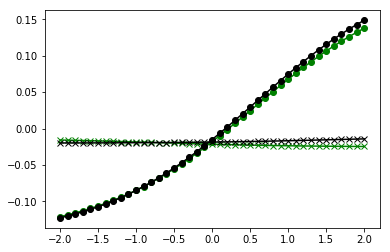

In [15]:
w_nat = [-0.1, 0.3,-0.1,0.1,-0.5]
probs1 = np.random.random_sample(4)
probs1 /= np.sum(probs1)
print(probs1)
probs2 = np.random.random_sample(4)
probs2 /= np.sum(probs2)
print(probs2)
x = np.array(range(-20,21))/10
x = np.reshape(x,(x.shape[0],1))
w = [0.3,-0.2,0.3,-0.6]
w = np.tile(w,(x.shape[0],1))
ws = np.hstack((x,w))

# plot_accuracy(plt.plot, 1, probs1, w_nat, ws, x, '.', "blue")
# plot_accuracy(plt.plot, 1, probs2, w_nat, ws, x, '.', "red")

plot_equal_odd(plt.plot, 1, 1, probs1, probs2, w_nat, ws, x, 'o', "green")
plot_pred_value_parity(plt.plot, 1, 1, probs1, probs2, w_nat, ws, x,'x', "green")
plot_equal_odd(plt.plot, 1, -1, probs1, probs2, w_nat, ws, x, 'o', "black")
plot_pred_value_parity(plt.plot, 1, -1, probs1, probs2, w_nat, ws, x, 'x', "black")


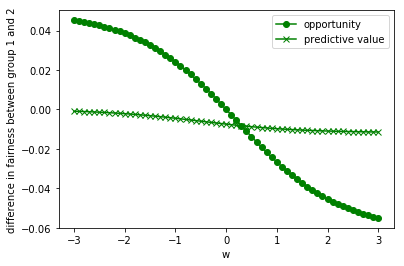

In [43]:
probs1 = [0.1, 0.2, 0.2, 0.2]
probs2 = [0.2, 0.2, 0.2, 0.2]
w_nat = np.array([0.3, 0.2, -0.1, 0.4, -0.3])

#We vary the first coordinate of w from -2 to 2 and plot the changes in the metrics
x = np.array(range(-30,31))/10
x = np.reshape(x,(x.shape[0],1))
w = [0.1,0.2,0.1,-0.3]
#w = [0,-10,-10,-0.4]
w = np.tile(w,(x.shape[0],1))
ws = np.hstack((w[:,:0], x,w[:,0:]))
#print(ws)
#plot_accuracy(plt.plot, 1, probs1, w_nat, ws, x, '.', "blue")
#plot_accuracy(plt.plot, 1, probs2, w_nat, ws, x, '.', "red")

plot_equal_odd(plt.plot, 1, 1, probs1, probs2, w_nat, ws, x, 'o', "green")
plot_pred_value_parity(plt.plot, 1, 1, probs1, probs2, w_nat, ws, x, 'x', "green")
#plot_equal_odd(plt.plot, 1, -1, probs1, probs2, w_nat, ws, x,'o', "black")
#plot_pred_value_parity(plt.plot, 1, -1, probs1, probs2, w_nat, ws, x, 'x', "black")

#print(Pr_Y(1,ws[-1],probs1) - Pr_Y(1,ws[-1],probs2))
plt.xlabel('w')
plt.ylabel('difference in fairness between group 1 and 2')
plt.legend()


-0.0012656256354710571


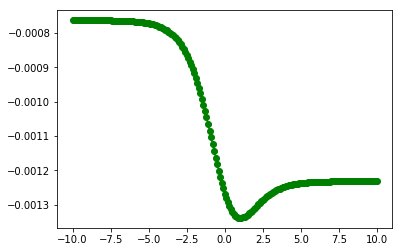

In [17]:
probs1 = [0.2, 0.2, 0.2, 0.2]
probs2 = [0.2, 0.2, 0.25, 0.2005]
w_nat = np.array([0.3, 0.2, 0.1, 0.4, -0.3])

#We vary the first coordinate of w from -2 to 2 and plot the changes in the metrics
x = np.array(range(-100,101))/10
x = np.reshape(x,(x.shape[0],1))
w = [0.1,0.2,0.1,-0.3]
#w = [0,-10,-10,-0.4]
w = np.tile(w,(x.shape[0],1))
ws = np.hstack((w[:,:3], x,w[:,3:]))
#print(ws)
#plot_accuracy(plt.plot, 1, probs1, w_nat, ws, x, '.', "blue")
#plot_accuracy(plt.plot, 1, probs2, w_nat, ws, x, '.', "red")

plot_equal_odd(plt.plot, 1, 1, probs1, probs2, w_nat, ws, x, 'o', "green")
#plot_pred_value_parity(plt.plot, 1, 1, probs1, probs2, w_nat, ws, x, 'x', "green")
#plot_equal_odd(plt.plot, 1, -1, probs1, probs2, w_nat, ws, x,'o', "black")
#plot_pred_value_parity(plt.plot, 1, -1, probs1, probs2, w_nat, ws, x, 'x', "black")

print(Pr_Y(1,ws[-1],probs1) - Pr_Y(1,ws[-1],probs2))

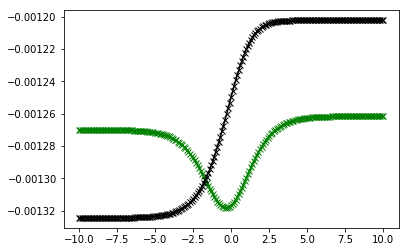

In [18]:
#plot_accuracy(plt.plot, 1, probs1, w_nat, ws, x, 4, '.', "blue")
#plot_accuracy(plt.plot, 1, probs2, w_nat, ws, x, 4, '.', "red")

plot_pred_value_parity(plt.plot, 1, 1, probs1, probs2, w_nat, ws, x,  'x', "green")
plot_pred_value_parity(plt.plot, 1, -1, probs1, probs2, w_nat, ws, x,  'x', "black")


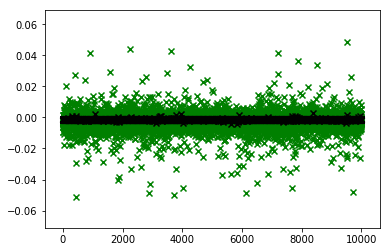

In [19]:
#We generate random ws and plot the spread of the metrics

ws = 2*np.random.random_sample((10000,5))-0.5                                                                                                        
ws = np.apply_along_axis(lambda x : x/np.sum(x), 1, ws)
x = range(10000)
# plot_accuracy(plt.scatter, 1, probs1, w_nat, ws, x, 4, '.', "blue")
# plot_accuracy(plt.scatter, 1, probs2, w_nat, ws, x, 4, '.', "red")

plot_equal_odd(plt.scatter, 1, 1, probs1, probs2, w_nat, ws, x, 'x', "green")
plot_pred_value_parity(plt.scatter, 1, 1, probs1, probs2, w_nat, ws, x, 'x', "black")

[0.35769854 0.31546316 0.12783722 0.19900108]
[0.21287504 0.2904423  0.32610275 0.1705799 ]


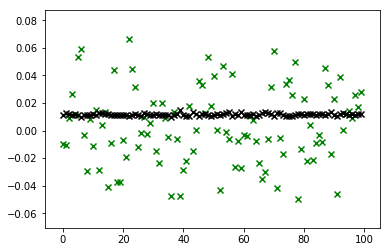

In [20]:
ws = 2*np.random.random_sample((100,4))
offset = -2*np.reshape(np.random.random_sample(100),(100,1))
#print(offset.shape)
ws = np.hstack((ws, offset))
probs1 = np.random.random_sample(4)
probs1 /= np.sum(probs1)
print(probs1)
probs2 = np.random.random_sample(4)
probs2 /= np.sum(probs2)
print(probs2)
#print(ws)
# ws = np.apply_along_axis(lambda x : x/np.sum(x), 1, ws)
x = range(100)
plot_equal_odd(plt.scatter, 1, 1, probs1, probs2, w_nat, ws, x, 'x', "green")
plot_pred_value_parity(plt.scatter, 1, 1, probs1, probs2, w_nat, ws, x, 'x', "black")